# Load packages

In [1]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import json
import numpy as np

In [2]:
import sys

sys.path.append("../../resource/DexiNed")
sys.path.append("../../src")

from model import DexiNed
from dataset import BIPEDv2, transforms

# Prepare

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epoch = 50
batch_size = 8
learning_rate = 1e-4
biped_dataset = BIPEDv2(
    "/home/yangk/intership_2025_COSYS/resource/DexiNed/BIPEDv2/BIPED/edges/imgs/train/rgbr/real/",
    "/home/yangk/intership_2025_COSYS/resource/DexiNed/BIPEDv2/BIPED/edges/edge_maps/train/rgbr/real/"
)
# test set
test_dataset = BIPEDv2(
    "/home/yangk/intership_2025_COSYS/resource/DexiNed/BIPEDv2/BIPED/edges/imgs/test/rgbr/",
    "/home/yangk/intership_2025_COSYS/resource/DexiNed/BIPEDv2/BIPED/edges/edge_maps/test/rgbr/"
)

model = DexiNed()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loader = DataLoader(biped_dataset, batch_size=4)
val_loader = DataLoader(test_dataset, batch_size=4)
logging = {
    'metadata': {},
    'train_loss': [],
    'val_loss': []
}


print(device)

cuda


# Train

In [4]:
import os
# set checkpoint file name
file_stem = "cpt_visibility_04"
logging['metadata'] = {
    "description": "with validation loss, and replace the sum of loss of each layers to the average", 
    "num_epoch":epoch, 
    "batch_size":batch_size, 
    "criterion": criterion.__class__.__name__, 
    "learning_rate": learning_rate
}

if not os.path.isfile(f"./checkpoints/{file_stem}.json"): # First train
    model = model.to(device)
    for e in range(epoch):
        # train step
        model.train()
        epoche_loss = []
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = sum([criterion(output.squeeze(), y) for output in outputs]) / len(outputs)
            loss.backward()
            optimizer.step()
            print("*", end="", flush=True)
            epoche_loss.append(loss.detach().item())
        logging['train_loss'].append(np.mean(epoche_loss))
        print(f"\nIn epoch {e}, the average  training  loss is {logging['train_loss'][-1]}")
        # validation step
        model.eval()
        val_epoch_loss = []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = sum([criterion(output.squeeze(), y) for output in outputs]) / len(outputs)
                val_epoch_loss.append(loss.detach().item())
        logging['val_loss'].append(np.mean(val_epoch_loss))
        print(f"\nIn epoch {e}, the average validation loss is {logging['val_loss'][-1]}")
    model = model.to('cpu')
    # save files
    # file_stem = "cpt_visibility_01"
    torch.save(model.state_dict(), f"./checkpoints/{file_stem}.pth")
    print(f"Succeed saving mdoel parameters in ./checkpoints/{file_stem}.pth.")
    with open(f"./checkpoints/{file_stem}.json", "w") as f:
        json.dump(logging, f)
    print(f"Succeed saving log in ./checkpoints/{file_stem}.json")
else: # already trained
    # load model
    model.load_state_dict(torch.load(f"./checkpoints/{file_stem}.pth", weights_only=True))
    # load log
    with open(f"./checkpoints/{file_stem}.json", 'r') as f:
        logging = json.load(f)
    # print the loss
    for e, (train_loss, val_loss) in enumerate(zip(logging['train_loss'], logging['val_loss'])):
        print("-".join(["-"]*30))
        print(f"\nIn epoch {e}, the average  training  loss is {train_loss}")
        print(f"\nIn epoch {e}, the average validation loss is {val_loss}")

-----------------------------------------------------------

In epoch 0, the average  training  loss is 649.6635845947266

In epoch 0, the average validation loss is 701.7112309382512
-----------------------------------------------------------

In epoch 1, the average  training  loss is 642.8128085327148

In epoch 1, the average validation loss is 691.923574594351
-----------------------------------------------------------

In epoch 2, the average  training  loss is 637.5531616210938

In epoch 2, the average validation loss is 685.8839252178485
-----------------------------------------------------------

In epoch 3, the average  training  loss is 633.2204794311524

In epoch 3, the average validation loss is 681.9429837740385
-----------------------------------------------------------

In epoch 4, the average  training  loss is 629.5756335449219

In epoch 4, the average validation loss is 677.9409109262319
-----------------------------------------------------------

In epoch 5, the aver

# Result

In [6]:
# take one example
img, y = biped_dataset.__getitem__(6, transform=False)
x = biped_dataset.transform(img)
# inference
model.eval()
with torch.no_grad():
    model.to(device)
    yhat = model(x.unsqueeze(0).to(device))[-1].squeeze()
    yhat = yhat.to('cpu')
    model.to('cpu')

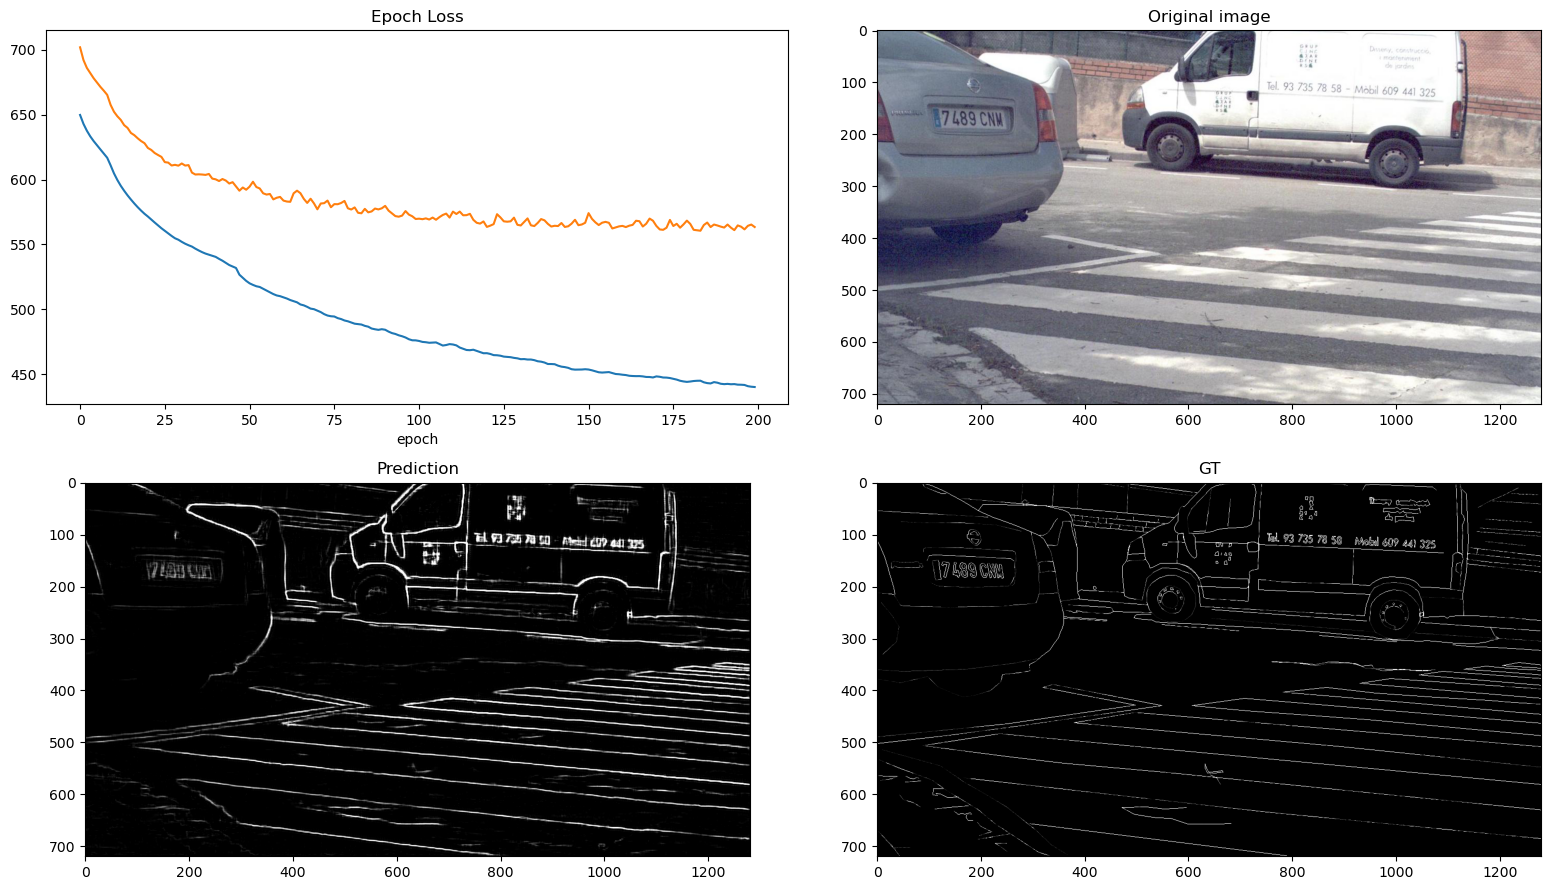

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# display
fig, axes = plt.subplots(2, 2, figsize=(16, 9))  

# Loss
axes[0,0].plot(logging['train_loss'])
axes[0,0].plot(logging['val_loss'])
axes[0,0].set_xlabel("epoch")
axes[0,0].set_title("Epoch Loss")

# original image
axes[0,1].imshow(img)
axes[0,1].set_title("Original image")
# axes[0,1].axis('off')  # 不显示坐标轴

# edge
def normalisation(img, percentile=95):
    res = img / np.percentile(img, percentile)
    res = np.where(res<0, 0, res)
    res = np.where(res>1, 1, res) 
    return res
axes[1,0].imshow(normalisation(yhat, 98), cmap="gray")
axes[1,0].set_title("Prediction")
# axes[1,0].axis('off')  # 不显示坐标轴
axes[1,1].imshow(normalisation(y, 98), cmap="gray")
axes[1,1].set_title("GT")
# axes[1,1].axis('off')  # 不显示坐标轴

plt.tight_layout()  # 自动调整子图间距
plt.show()

In [10]:
from nms import non_max_suppression_torch
import cv2
# Sobel 边缘 + 方向
gx = cv2.Sobel(yhat.detach().numpy(), cv2.CV_64F, 1, 0, ksize=3)
gy = cv2.Sobel(yhat.detach().numpy(), cv2.CV_64F, 0, 1, ksize=3)

mag = np.hypot(gx, gy).astype(np.float32)
dir = np.degrees(np.arctan2(gy, gx)).astype(np.float32)

# 转换为 PyTorch Tensor
edge_mag_t = torch.tensor(mag).unsqueeze(0).unsqueeze(0)  # shape (1, 1, H, W)
edge_dir_t = torch.tensor(dir).unsqueeze(0).unsqueeze(0)

# 应用 NMS
nms_edge = non_max_suppression_torch(edge_mag_t, edge_dir_t)

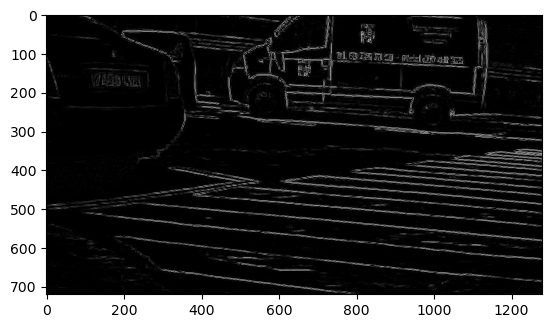

In [16]:
import matplotlib.pyplot as plt
plt.imshow(normalisation(nms_edge[0,0], 98), cmap="gray")
plt.show()